In [1]:
import os, json, random, math, scipy, wandb
import numpy as np
import mediapipe as mp 
import cv2
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedGroupKFold 
from types import SimpleNamespace
from pathlib import Path
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'scipy'

In [8]:
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [9]:
cfg = SimpleNamespace()

In [10]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [11]:
DATA_DIR         = Path('D:/New folder/') 
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

In [12]:
cfg.PREPROCESS_DATA = True
cfg.TRAIN_MODEL = True
cfg.N_ROWS = 543
cfg.N_DIMS = 3
cfg.DIM_NAMES = ['x', 'y', 'z']
cfg.SEED = 42
cfg.NUM_CLASSES = 250
cfg.IS_INTERACTIVE = True
cfg.VERBOSE = 2
cfg.INPUT_SIZE = 32
cfg.BATCH_ALL_SIGNS_N = 4
cfg.BATCH_SIZE = 256
cfg.N_EPOCHS = 100
cfg.LR_MAX = 1e-3
cfg.N_WARMUP_EPOCHS = 0
cfg.WD_RATIO = 0.05
cfg.MASK_VAL = 4237

In [13]:
train = pd.read_csv(TRAIN_CSV_PATH)
N_SAMPLES = len(train)

In [14]:
train['sign_ord'] = train['sign'].astype('category').cat.codes
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [15]:
train.head()

,path,participant_id,sequence_id,sign,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [16]:
N_PARTICIPANTS = train.participant_id.nunique()
sgkf = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=43)
train['fold'] = -1
for i, (train_idx, val_idx) in enumerate(sgkf.split(train.index, train.sign, train.participant_id)):
    train.loc[val_idx, 'fold'] = i
train.head(2)

,path,participant_id,sequence_id,sign,sign_ord,fold
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,2


In [17]:
train_idxs = train.query("fold!=0").index.values
val_idxs = train.query("fold==0").index.values

In [18]:
len(train_idxs), len(val_idxs)

(81735, 12742)

In [19]:
# landmark indices in original data
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
LEFT_HAND_IDXS0  = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0       = np.arange(502, 512)
LANDMARK_IDXS0   = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0       = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS           = LANDMARK_IDXS0.size
N_COLS, LANDMARK_IDXS0

(92,
 array([ 61, 185,  40,  39,  37,   0, 267, 269, 270, 409, 291, 146,  91,
        181,  84,  17, 314, 405, 321, 375,  78, 191,  80,  81,  82,  13,
        312, 311, 310, 415,  95,  88, 178,  87,  14, 317, 402, 318, 324,
        308, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
        480, 481, 482, 483, 484, 485, 486, 487, 488, 522, 523, 524, 525,
        526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
        539, 540, 541, 542, 502, 503, 504, 505, 506, 507, 508, 509, 510,
        511]))

In [20]:
# Landmark indices in processed data
LIPS_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS  = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()
print(HAND_IDXS.shape)

(42,)


In [21]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,cfg.N_ROWS,cfg.N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Keep only non-empty frames in data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 
        
        # Number of non-empty frames
        N_FRAMES = tf.shape(data)[0]
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)
        
        if N_FRAMES < cfg.INPUT_SIZE:
            # Video fits in cfg.INPUT_SIZE
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, cfg.INPUT_SIZE-N_FRAMES]], constant_values=-1)
            data = tf.pad(data, [[0, cfg.INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        else:
            # Video needs to be downsampled to cfg.INPUT_SIZE
            if N_FRAMES < cfg.INPUT_SIZE**2:
                repeats = tf.math.floordiv(cfg.INPUT_SIZE * cfg.INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)
            
            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), cfg.INPUT_SIZE)
            if tf.math.mod(len(data), cfg.INPUT_SIZE) > 0:
                pool_size += 1
            if pool_size == 1:
                pad_size = (pool_size * cfg.INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * cfg.INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [cfg.INPUT_SIZE, -1, N_COLS, cfg.N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [cfg.INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [22]:
sample = load_relevant_data_subset(DATA_DIR/train.path[0])
sample.shape

(23, 543, 3)

In [23]:
data, non_empty_frames_idxs = preprocess_layer(sample)
data.shape, non_empty_frames_idxs

(TensorShape([32, 92, 3]),
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 22., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.], dtype=float32)>)

In [24]:
# free up RAM, delete variables as we go
del data; del non_empty_frames_idxs

In [25]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

In [26]:
def get_data(file_path):
    data = load_relevant_data_subset(file_path)
    data = preprocess_layer(data)
    return data

In [27]:
def get_x_y():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, cfg.INPUT_SIZE], -1, dtype=np.float32)
    print(NON_EMPTY_FRAME_IDXS)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(DATA_DIR/file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0: return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    return X, y, NON_EMPTY_FRAME_IDXS

In [28]:
cfg.PREPROCESS_DATA = False

In [29]:
if cfg.PREPROCESS_DATA:
    X, y, NON_EMPTY_FRAME_IDXS = get_x_y()
else:
    X = np.load('X.npy')
    y = np.load('y.npy')
    NON_EMPTY_FRAME_IDXS = np.load('NON_EMPTY_FRAME_IDXS.npy')

In [30]:
code = pd.read_parquet('output_1.parquet')

In [31]:
LIPS_MEAN_X  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X   = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y   = np.zeros([LIPS_IDXS.size], dtype=np.float32)
for col, ll in enumerate(tqdm( np.transpose(X[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        #print(dim, len(l))
        v = l[np.nonzero(l)]
        if dim == 0: # X
            LIPS_MEAN_X[col] = v.mean()
            LIPS_STD_X[col] = v.std()
        if dim == 1: # Y
            LIPS_MEAN_Y[col] = v.mean()
            LIPS_STD_Y[col] = v.std()
        
LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

  0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
# LEFT HAND
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# RIGHT HAND
RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, cfg.N_DIMS, -1]))):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            else:
                RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
        if dim == 1: # Y
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            else: # RIGHT HAND
                RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()
        
LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T


  0%|          | 0/42 [00:00<?, ?it/s]

In [33]:
# POSE
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            POSE_MEAN_X[col] = v.mean()
            POSE_STD_X[col] = v.std()
        if dim == 1: # Y
            POSE_MEAN_Y[col] = v.mean()
            POSE_STD_Y[col] = v.std()
        
POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=cfg.BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, cfg.NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(cfg.NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(cfg.NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [35]:
dummy_dataset = get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS)
X_batch, y_batch = next(dummy_dataset)
print(X_batch)
X_batch.keys(), X_batch['frames'].shape

{'frames': array([[[[ 4.99982625e-01,  6.28041029e-01, -1.33824383e-03],
         [ 5.02689958e-01,  6.23699784e-01, -1.05463741e-02],
         [ 5.07382393e-01,  6.19037449e-01, -2.02609431e-02],
         ...,
         [-2.28759591e-02,  1.24664307e+00, -1.19047284e+00],
         [ 7.16434181e-01,  7.56501794e-01, -1.79123425e+00],
         [-1.72850001e-03,  1.22810888e+00, -1.03676283e+00]],

        [[ 4.97573704e-01,  6.28199339e-01, -2.01072684e-03],
         [ 5.00419557e-01,  6.23996854e-01, -1.13050025e-02],
         [ 5.05087316e-01,  6.19480789e-01, -2.10849196e-02],
         ...,
         [-1.88705344e-02,  1.24508464e+00, -9.56571579e-01],
         [ 7.25015402e-01,  7.37008631e-01, -1.88841856e+00],
         [-2.94903730e-04,  1.22672141e+00, -8.08077157e-01]],

        [[ 4.91760552e-01,  6.29251301e-01, -3.33652599e-03],
         [ 4.94506329e-01,  6.25109851e-01, -1.25338417e-02],
         [ 4.99136060e-01,  6.20558977e-01, -2.21156944e-02],
         ...,
         [-1.

(dict_keys(['frames', 'non_empty_frame_idxs']), (1000, 32, 92, 3))

In [36]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [37]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 12))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

In [39]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [40]:
class CustomEmbedding(tf.keras.Model):
    def __init__(self):
        super(CustomEmbedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, cfg.INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(cfg.INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            cfg.INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * cfg.INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [41]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [42]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([cfg.INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,cfg.INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,cfg.INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips = tf.reshape(lips, [-1, cfg.INPUT_SIZE, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,cfg.INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    left_hand = tf.reshape(left_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,cfg.INPUT_SIZE, 21, 2])
    right_hand = tf.where(
            tf.math.equal(right_hand, 0.0),
            0.0,
            (right_hand - RIGHT_HANDS_MEAN) / RIGHT_HANDS_STD,
        )
    right_hand = tf.reshape(right_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,cfg.INPUT_SIZE, 10, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    pose = tf.reshape(pose, [-1, cfg.INPUT_SIZE, 10*2])
    x = lips, left_hand, right_hand, pose
    x = CustomEmbedding()(lips, left_hand, right_hand, pose, non_empty_frame_idxs)
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classification Layer
    x = tf.keras.layers.Dense(cfg.NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    lr_metric = get_lr_metric(optimizer)
    metrics = ["acc",lr_metric]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


In [43]:
tf.keras.backend.clear_session()
model_one = get_model()
model_one.load_weights('D:/New folder/model_one.h5')

In [44]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=cfg.N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

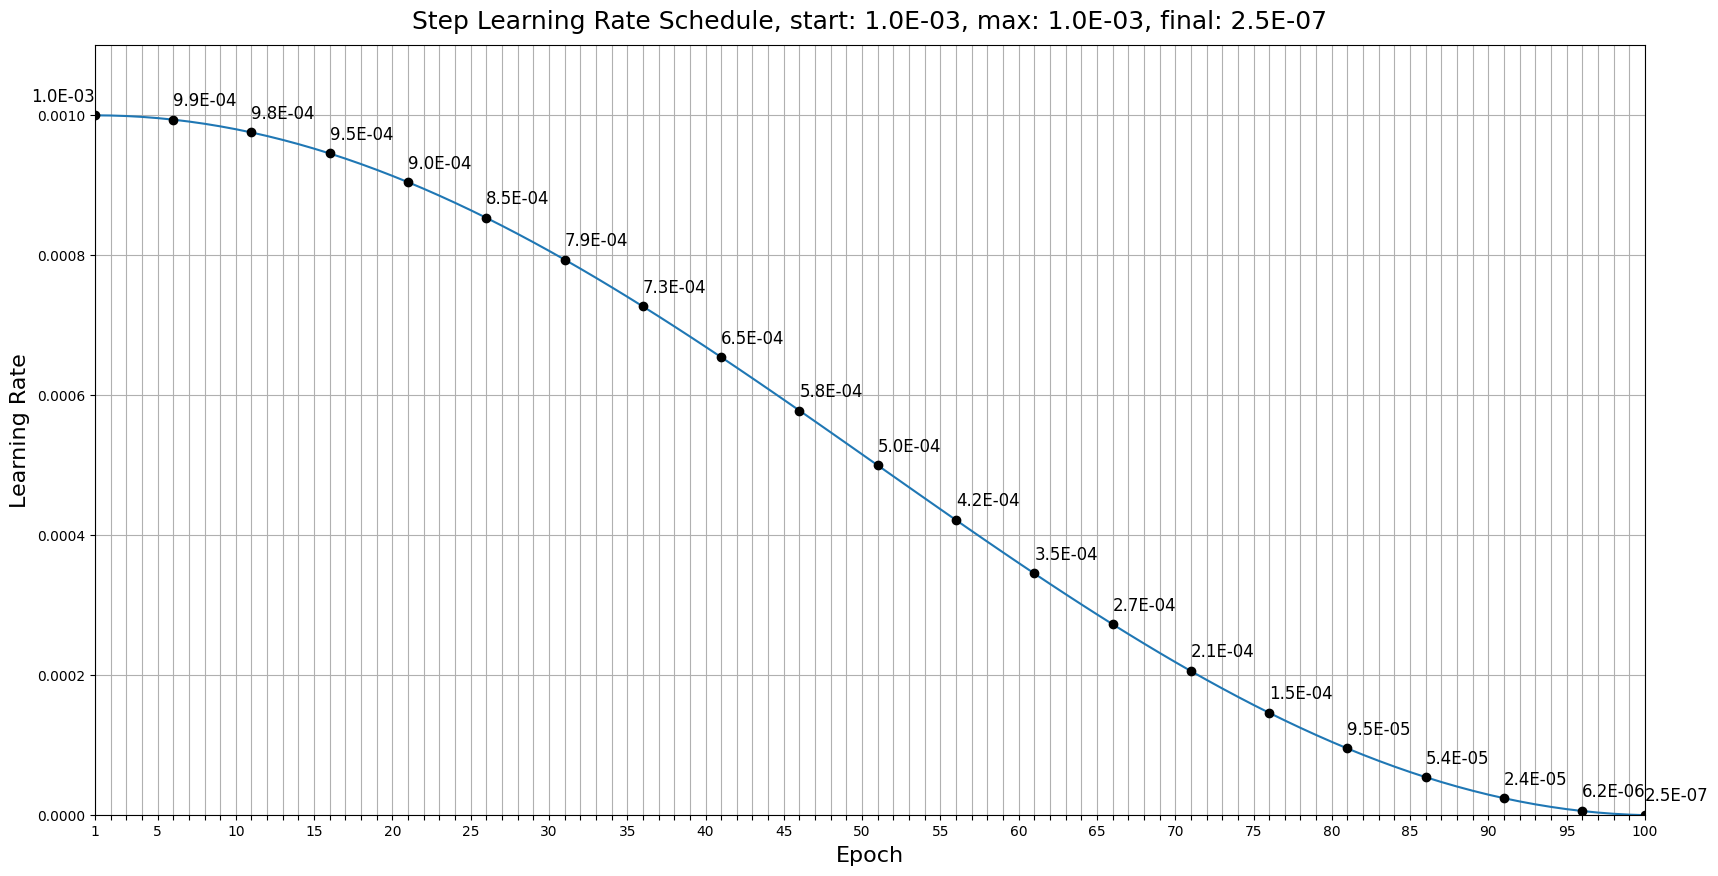

In [45]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=cfg.N_WARMUP_EPOCHS, lr_max=cfg.LR_MAX, num_cycles=0.50) for step in range(cfg.N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=cfg.N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [46]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=cfg.WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model_one.optimizer.weight_decay = model_one.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model_one.optimizer.learning_rate.numpy():.2e}, weight decay: {model_one.optimizer.weight_decay.numpy():.2e}')

In [47]:
%%timeit -n 100
if cfg.TRAIN_MODEL:
    # Verify model_one prediction is <<<100ms
    model_one.predict_on_batch({ 'frames': X[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS[:1] })

25.4 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
X_train = X[train_idxs]
X_val = X[val_idxs]
NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
y_train = y[train_idxs]
y_val = y[val_idxs]

In [46]:
# delete variables as we go to free up RAM
del X_train; del y_train

In [47]:
if cfg.TRAIN_MODEL:
    tf.keras.backend.clear_session()
    callbacks=[
            lr_callback,
            WeightDecayCallback(),
           # wandb.keras.WandbCallback()
    ]
    model_one.fit(
        x=get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS),
        steps_per_epoch=len(X) // (cfg.NUM_CLASSES * cfg.BATCH_ALL_SIGNS_N),
        epochs=cfg.N_EPOCHS,
        batch_size=cfg.BATCH_SIZE,
        callbacks=callbacks,
        verbose = 2,)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/100
94/94 - 1026s - loss: 3.4567 - acc: 0.2598 - lr: 0.0010 - 1026s/epoch - 11s/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997532801828658.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/100
94/94 - 1004s - loss: 1.6325 - acc: 0.5897 - lr: 9.9975e-04 - 1004s/epoch - 11s/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009990133642141358.
learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 3/100
94/94 - 996s - loss: 1.2195 - acc: 0.6881 - lr: 9.9901e-04 - 996s/epoch - 11s/step

Epoch 4: LearningRateScheduler setting learning rate to 0.00099778098230154.
learning rate: 9.98e-04, weight decay: 4.99e-05
Epoch 4/100
94/94 - 956s - loss: 1.0116 - acc: 0.7375 - lr: 9.9778e-04 - 956s/epoch - 10s/step

Epoch 5: LearningRateScheduler setting learning rate to 0.000996057350657239.
learning rate: 9.96e-04, weight decay: 4.98e-05

In [48]:
# save model artifacts
if cfg.TRAIN_MODEL:# serialize weights to HDF5
    model_one.save_weights("model_one.h5")

In [54]:
y_val_pred = model_one.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
np.mean(y_val == y_val_pred)

399/399 - 62s - 62s/epoch - 155ms/step


1.0

In [49]:
def read_parquet(path): 
    return pd.read_parquet(path)

In [50]:
label_map = json.load(open(LABEL_MAP_PATH, 'r'))

In [51]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

In [52]:
LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33
## average over the entire face

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))
pose_landmarks = list(range(POSE_OFFSET, POSE_OFFSET+33))

cfg.SEGMENTS=3
cfg.NUM_FRAMES=15
cfg.DROP_Z=True
cfg.averaging_sets=[
        [0, 468],
        [POSE_OFFSET, 33],
    ]
cfg.average_over_pose=True


point_landmarks = lip_landmarks + left_hand_landmarks+ right_hand_landmarks
if not cfg.average_over_pose: 
    point_landmarks = point_landmarks + pose_landmarks


TOT_LANDMARKS = len(point_landmarks) + len(cfg.averaging_sets)
if cfg.DROP_Z:
    INPUT_SHAPE = (cfg.NUM_FRAMES,TOT_LANDMARKS*2)
else:
    INPUT_SHAPE = (cfg.NUM_FRAMES,TOT_LANDMARKS*3)
    
FLAT_INPUT_SHAPE = (INPUT_SHAPE[0] + 2 * (cfg.SEGMENTS + 1)) * INPUT_SHAPE[1]

INPUT_SHAPE, TOT_LANDMARKS, FLAT_INPUT_SHAPE

((15, 168), 84, 3864)

In [53]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

In [54]:
def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

In [55]:
def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

In [56]:
class  FeatureGen_1(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen_1, self).__init__()
    def call(self, x_in):
        if not isinstance(x_in, (np.ndarray, tf.Tensor)): 
            x_in = load_relevant_data_subset(x_in)
        if cfg.DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in cfg.averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x

        for i in range(cfg.SEGMENTS):
            # once right pad, once left
            p0 = tf.where( ((tf.shape(x_padded)[0] % cfg.SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % cfg.SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, cfg.SEGMENTS)
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds(x, axis=0))

        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(
            tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), 
            [cfg.NUM_FRAMES, TOT_LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

In [57]:
feature_gen1 = FeatureGen_1()
feature_gen1(load_relevant_data_subset(DATA_DIR/train.path[0])).shape

TensorShape([1, 3864])

In [58]:
X_PATH = DATA_DIR/'asl-features/feature_data.npy'
Y_PATH = DATA_DIR/'asl-features/feature_labels.npy'

In [59]:
%%time
X = np.load(X_PATH)
y = np.load(Y_PATH)
X.shape, y.shape

CPU times: total: 1.97 s
Wall time: 16.2 s


((94477, 3864), (94477,))

In [60]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
label_map = json.load(open(LABEL_MAP_PATH, 'r'))
# train_df['label'] = train_df.sign.map(label_map
train_df.shape

(94477, 4)

In [61]:
N_PARTICIPANTS = train_df.participant_id.nunique()
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=43)
train_df['fold'] = -1
for i, (train_idx, val_idx) in enumerate(sgkf.split(train_df.index, train_df.sign, train_df.participant_id)):
    train_df.loc[val_idx, 'fold'] = i
train_df.head()

,path,participant_id,sequence_id,sign,fold
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,0
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,3
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,6
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,3
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,8


In [62]:
train_idxs = train_df.query("fold!=0").index.values
val_idxs = train_df.query("fold==0").index.values

x_train, y_train = X[train_idxs], y[train_idxs]
x_test, y_test = X[val_idxs], y[val_idxs]

n_classes = train_df.sign.nunique() #250

In [63]:
cfg.BLOCK_SIZES = [2048, 1024, 512]
cfg.FLAT_FRAME_SHAPE = x_train.shape[1]
cfg.DROPOUTS = [0.3, 0.1, 0.1]
cfg.LEARNING_RATE = 1e-3
cfg.training_data_path = (X_PATH, Y_PATH)

In [64]:
cfg.EPOCHS = 100
cfg.BATCH_SIZE = 256

decay_steps = ((len(x_train)//cfg.BATCH_SIZE)*cfg.EPOCHS)

cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = cfg.LEARNING_RATE,
    decay_steps = decay_steps,
    alpha=0.001
)
optimizer = tf.keras.optimizers.Adam(cosine_decay_scheduler)


def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def get_model(n_labels=250, flat_frame_len=cfg.FLAT_FRAME_SHAPE):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs
    
    # Define layers
    for i in range(len(cfg.DROPOUTS)):
        x = fc_block(
            x, output_channels=cfg.BLOCK_SIZES[i], 
            dropout=cfg.DROPOUTS[i]
        )
    
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

lr_metric = get_lr_metric(optimizer)
model_two = get_model()
model_two.compile(optimizer, "sparse_categorical_crossentropy", 
              metrics=["acc", lr_metric])

In [65]:
tf.keras.backend.clear_session()
model_two.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3864)]            0         
                                                                 
 dense_1 (Dense)             (None, 2048)              7915520   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                           

In [66]:
del x_train; del y_train; 

In [77]:
if cfg.TRAIN_MODEL:
    history = model_two.fit(
        X, y,
        epochs=cfg.EPOCHS, 
        batch_size=cfg.BATCH_SIZE,
        callbacks=callbacks, 
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 2.47e-07, weight decay: 1.23e-08
Epoch 1/100
370/370 [==============================] - 93s 233ms/step - loss: 4.4528 - acc: 0.0768 - lr: 9.9970e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997532801828658.
learning rate: 2.47e-07, weight decay: 1.23e-08
Epoch 2/100
370/370 [==============================] - 78s 211ms/step - loss: 3.2713 - acc: 0.2299 - lr: 9.9879e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009990133642141358.
learning rate: 2.47e-07, weight decay: 1.23e-08
Epoch 3/100
370/370 [==============================] - 78s 211ms/step - loss: 2.7692 - acc: 0.3293 - lr: 9.9727e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00099778098230154.
learning rate: 2.47e-07, weight decay: 1.23e-08
Epoch 4/100
370/370 [==============================] - 77s 207ms/step - loss: 2.4798 - acc: 0.3891 - lr: 9.9515e-04

Epoch 5: LearningRateScheduler setting le

In [78]:
del X; del y

In [74]:
if cfg.TRAIN_MODEL:
    model_two.save_weights(DATA_DIR/'final_model_two.h5')

In [68]:
model_two.load_weights('D:/New folder/final_model_two.h5')

In [69]:
y_val_pred = model_two.predict(x_test).argmax(axis=1)
np.mean(y_test == y_val_pred)

285/285 [==============================] - 5s 16ms/step


0.005484861781483106

In [70]:
asl_model = keras.models.load_model(DATA_DIR/'asl_model')

In [71]:
ROWS_PER_FRAME = 543
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))
DROP_Z = False

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if DROP_Z:
    INPUT_SHAPE1 = (NUM_FRAMES,LANDMARKS*2)
else:
    INPUT_SHAPE1 = (NUM_FRAMES,LANDMARKS*3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE1[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE1[1]
print(FLAT_INPUT_SHAPE)

84
5796


In [72]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds1(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE1[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

class FeatureGen_2(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen_2, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds1(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds1(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE1[0]*INPUT_SHAPE1[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x
#print(FeatureGen_2()(tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")))
#FeatureGen_2()(load_relevant_data_subset(train_df.path[0]))
feature_gen2 = FeatureGen_2()
feature_gen2(load_relevant_data_subset(DATA_DIR/train.path[0])).shape

TensorShape([1, 5796])

In [73]:
class FinalModel(tf.keras.Model):
    def __init__(self, model_1, model_2, model_3, pp_layer_1, pp_layer_2, pp_layer_3):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.pp_layer_1 =  pp_layer_1
        self.pp_layer_2 = pp_layer_2
        self.pp_layer_3 = pp_layer_3

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, cfg.N_ROWS, cfg.N_DIMS], dtype=tf.float32, name='inputs')])        
    def __call__(self, inputs):
        #model-2 (transformer)
        x, non_empty_frame_idxs = self.pp_layer_2(inputs)
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        _outputs_2 = self.model_2({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        _outputs_2 = tf.squeeze(_outputs_2, axis=0)
        
        # model-1 (custom)
        x = self.pp_layer_1(tf.cast(inputs, dtype=tf.float32))
        _outputs_1 = self.model_1(x)[0, :]
        
        # model-3 (custom)
        x = self.pp_layer_3(tf.cast(inputs, dtype=tf.float32))
        _outputs_3 = self.model_3(x)[0, :]
        
        outputs = (0.7 * _outputs_2) + ((0.60* _outputs_3)+(0.30* _outputs_1))/3
  
        return {'outputs': outputs}

In [74]:
final_model = FinalModel(model_two, model_one, asl_model, feature_gen1,preprocess_layer, feature_gen2)

In [75]:
final_model.layers

In [73]:
demo_raw_data = load_relevant_data_subset(DATA_DIR/train['path'].values[1])
demo_output = final_model(demo_raw_data)["outputs"]
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[1]["sign_ord"]}')

demo_prediction: 232, correct: 232


In [ ]:
df = pd.read_parquet(DATA_DIR/train.path[0])
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_holistic = mp.solutions.holistic

In [ ]:
def create_frame_landmark_df(results,frame):
    df_skel = df[['type','landmark_index']].drop_duplicates().reset_index(drop=True).copy()
    face = pd.DataFrame()
    pose = pd.DataFrame()
    left_hand = pd.DataFrame()
    right_hand =pd.DataFrame()

    if results.face_landmarks:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i,['x','y','z']] = [point.x,point.y,point.z]
    if results.pose_landmarks:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i,['x','y','z']] = [point.x,point.y,point.z]
    if results.left_hand_landmarks:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i,['x','y','z']] = [point.x,point.y,point.z]
    if results.right_hand_landmarks:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i,['x','y','z']] = [point.x,point.y,point.z]
            
    face = face.reset_index().rename(columns={'index':'landmark_index'}).assign(type='face')
    pose = pose.reset_index().rename(columns={'index':'landmark_index'}).assign(type='pose')
    left_hand = left_hand.reset_index().rename(columns={'index':'landmark_index'}).assign(type='left_hand')
    right_hand = right_hand.reset_index().rename(columns={'index':'landmark_index'}).assign(type='right_hand')

    landmarks = pd.concat([face,pose,left_hand,right_hand]).reset_index(drop=True)
    landmarks =  df_skel.merge(landmarks, on = ['type','landmark_index'], how = 'left')
    landmarks = landmarks.assign(frame=frame)
    return landmarks

In [ ]:
def do_capture_loop():
    all_landmarks = []    
    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:
        frame = 0
        while cap.isOpened():
            frame +=1
            success,image = cap.read()
            if not success:
                print("Ignoring empty camera frame")
                continue
            image.flags.writeable = False
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            #Create landmark dataframe
            landmarks = create_frame_landmark_df(results,frame)
            all_landmarks.append(landmarks)
            image.flags.writeable = True
            image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles
                .get_default_pose_landmarks_style())
            cv2.imshow('MediaPipe Holistic',cv2.flip(image,1))
            if cv2.waitKey(5) & 0xFF == 27:
                cap.release()
                cv2.destroyAllWindows()
                break
    return all_landmarks

In [ ]:
landmarks = do_capture_loop()
landmarks = pd.concat(landmarks).reset_index(drop=True).to_parquet("output_6.parquet")

In [ ]:
fig = px.scatter_3d(face,x='x',y='y',z='z',size_max=1)
fig.update_traces(marker_size=2.0)
fig.show() 

In [111]:
raw_data = load_relevant_data_subset('D:/New folder/output_6.parquet')
output = final_model(raw_data)["outputs"]
prediction = output.numpy().argmax()
print(prediction)

194


In [112]:
ORD2SIGN[prediction]

'shhh'

: 

In [2]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('./model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'tf' is not defined

In [ ]:
if cfg.TRAIN_MODEL:
    final_model.save_weights('final_model.h5')